In [33]:
import torch
import torch.nn.functional as F
import random
import os
import numpy as np
import zipfile
import glob
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from einops import rearrange, repeat
from torch import nn
from torch import optim
from tqdm import tqdm


In [22]:
MIN_NUM_PATCHES = 16

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        # 残差连接: fn(x) + x
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        # 输入全连接层之前进行Laryer Normalization
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    # 前馈神经网络
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        # 两个使用GELU和Dropout的全连接层
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# 多头自注意力层
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        
        # 获取q,k,v
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        
        # 输入序列x:[batch_size, patch_num, pathch_embedding_dim]
        b, n, _, h = *x.shape, self.heads

        # q,k,v:([batch, patch_num, head_num*head_dim],[...],[...])
        qkv = self.to_qkv(x).chunk(3, dim = -1)

        # 拆分q,k,v为多头
        # [batch, patch_num, head_num*head_dim] -> 
        # [batch, head_num, patch_num, head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # transpose(k) * q / sqrt(head_dim) -> 
        # [batch, head_num, patch_num, patch_num]
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        # mask value: -inf
        mask_value = -torch.finfo(dots.dtype).max

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1],  \
                'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        # value * attention matrix -> output
        out = torch.einsum('bhij,bhjd->bhid', attn, v)

        # 拼接输出 -> [batch, patch_num, head_num*head_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')

        # Linear + Dropout
        out =  self.to_out(out)

        # 输出尺寸: [batch, patch_num, embedding_dim]
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            # 重复使用多头注意力层和前馈神经网络
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, 
                                                dim_head = dim_head, 
                                                dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, 
                                                  dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, 
                 num_classes, dim, depth, heads, 
                 mlp_dim, pool = 'cls', channels = 3, 
                 dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0,  \
            'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES,  \
            f'your number of patches ({num_patches}) is way \
            too small for attention to be effective  \
            (at least 16). Try decreasing your patch size'
        assert pool in {'cls', 'mean'}, \
            'pool type must be either cls (cls token) \
            or mean (mean pooling)'

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, mask = None):
        p = self.patch_size

        # rearrange: convert img[batch, c, h, w] -> patchs[batch, patch_num, patch_size*patch_size*c]
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        
        # embedding every patch vector to embedding size: [batch, patch_num, embedding_size]
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape
        
        # repeat class token to batch_size and cat to x
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)

        # add position embedding
        # NOTES: position embedding is random initialized and learnable
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        # transformer: x[batch, patch_num + 1, embedding_size] -> x[batch, patch_num + 1, embedding_size]
        x = self.transformer(x, mask)

        # classification: using cls_token output
        # mean: using all tokens' mean value
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        # Identity layer
        x = self.to_latent(x)

        # MLP classification layer
        return self.mlp_head(x)

In [3]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [8]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

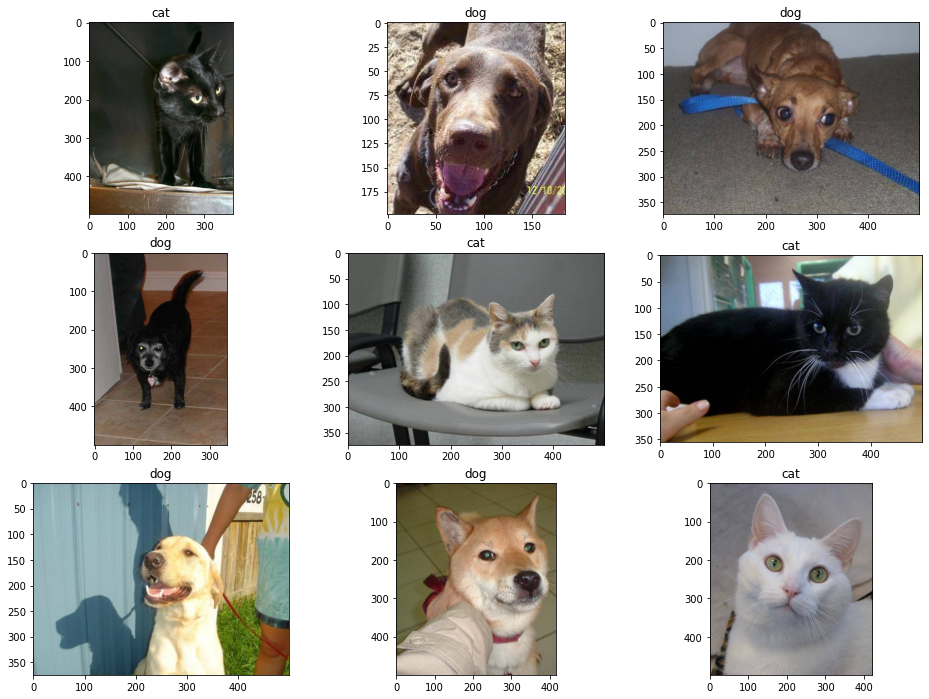

In [14]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [15]:
train_list, valid_list = train_test_split(
    train_list, test_size=0.2,
    stratify=labels, random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [17]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [18]:
train_data = CatsDogsDataset(
    train_list, transform=train_transforms)
valid_data = CatsDogsDataset(
    valid_list, transform=test_transforms)
test_data = CatsDogsDataset(
    test_list, transform=test_transforms)
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(
    dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))

20000 313


In [20]:
print(len(valid_data), len(valid_loader))

5000 79


In [35]:
device = 'cuda'

In [36]:
model = ViT( 
    image_size=224,
    patch_size=32,
    num_classes=2,
    channels=3,
    dim=128,
    depth=12,
    heads=8,
    mlp_dim=128
).to(device)

In [37]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [38]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - \
        acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - \
        val_acc: {epoch_val_accuracy:.4f}\n"
    )

100%|██████████| 313/313 [06:45<00:00,  1.30s/it]


Epoch : 1 - loss : 0.6911 - acc: 0.5266 - val_loss : 0.6780 - val_acc: 0.5722



100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


Epoch : 2 - loss : 0.6818 - acc: 0.5597 - val_loss : 0.6712 - val_acc: 0.5898



100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


Epoch : 3 - loss : 0.6769 - acc: 0.5678 - val_loss : 0.6679 - val_acc: 0.5979



100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


Epoch : 4 - loss : 0.6758 - acc: 0.5765 - val_loss : 0.6611 - val_acc: 0.6019



100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


Epoch : 5 - loss : 0.6716 - acc: 0.5794 - val_loss : 0.6560 - val_acc: 0.6025



100%|██████████| 313/313 [01:55<00:00,  2.70it/s]


Epoch : 6 - loss : 0.6615 - acc: 0.5973 - val_loss : 0.6433 - val_acc: 0.6379



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Epoch : 7 - loss : 0.6528 - acc: 0.6073 - val_loss : 0.6260 - val_acc: 0.6519



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Epoch : 8 - loss : 0.6417 - acc: 0.6271 - val_loss : 0.6073 - val_acc: 0.6697



100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


Epoch : 9 - loss : 0.6287 - acc: 0.6410 - val_loss : 0.5925 - val_acc: 0.6899



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Epoch : 10 - loss : 0.6186 - acc: 0.6528 - val_loss : 0.5802 - val_acc: 0.6936



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Epoch : 11 - loss : 0.6052 - acc: 0.6657 - val_loss : 0.5699 - val_acc: 0.7002



100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch : 12 - loss : 0.6004 - acc: 0.6684 - val_loss : 0.5586 - val_acc: 0.7152



100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch : 13 - loss : 0.5939 - acc: 0.6737 - val_loss : 0.5541 - val_acc: 0.7195



100%|██████████| 313/313 [02:00<00:00,  2.61it/s]


Epoch : 14 - loss : 0.5879 - acc: 0.6816 - val_loss : 0.5449 - val_acc: 0.7314



100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch : 15 - loss : 0.5828 - acc: 0.6869 - val_loss : 0.5417 - val_acc: 0.7306



100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


Epoch : 16 - loss : 0.5798 - acc: 0.6895 - val_loss : 0.5526 - val_acc: 0.7152



100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch : 17 - loss : 0.5784 - acc: 0.6912 - val_loss : 0.5330 - val_acc: 0.7366



100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch : 18 - loss : 0.5702 - acc: 0.6994 - val_loss : 0.5365 - val_acc: 0.7296



100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch : 19 - loss : 0.5691 - acc: 0.7024 - val_loss : 0.5235 - val_acc: 0.7425



100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


Epoch : 20 - loss : 0.5637 - acc: 0.7014 - val_loss : 0.5257 - val_acc: 0.7425

